# Movie recommendation system

![](https://fr.web.img5.acsta.net/pictures/19/02/25/17/06/0818764.jpg)

# Menu 

- Exploratory Data Analysis(EDA)
- Import dataset to neo4j 
- Create node 
- Content based filtering
- Collaborative Filtering
    - Memory based collaborative filtering
        - User-Item Filtering
        - Item-Item Filtering
    - Model based collaborative filtering
        - Single Value Decomposition(SVD)
        - SVD++
- Evaluating Collaborative Filtering using SVD
- Hybrid Model

# Import library

In [3]:
import pandas as pd
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [9]:
!pip install py2neo

# Create connection to neo4j 

In [10]:
import csv
from py2neo import Graph, Node
import os
import time

HOST = os.environ.get("NEO4J_HOST", "localhost")
PORT = 7687
USER = "neo4j"
PASS = "01662996260"  # default


graph = Graph("bolt://" + HOST + ":7687", auth=(USER, PASS))


# Dataset: Movielens
https://grouplens.org/datasets/movielens/25m/

In [4]:
# Reading ratings file
ratings = pd.read_csv(r"D:\doan\ratingss.csv", sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('D:\doan\moviess.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [5]:
df_movies = movies 
df_ratings = ratings 

# Exploratory Data Analysis(EDA)

In [16]:
df_movies.head(5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

### Most popular genres of movie released

<BarContainer object of 19 artists>

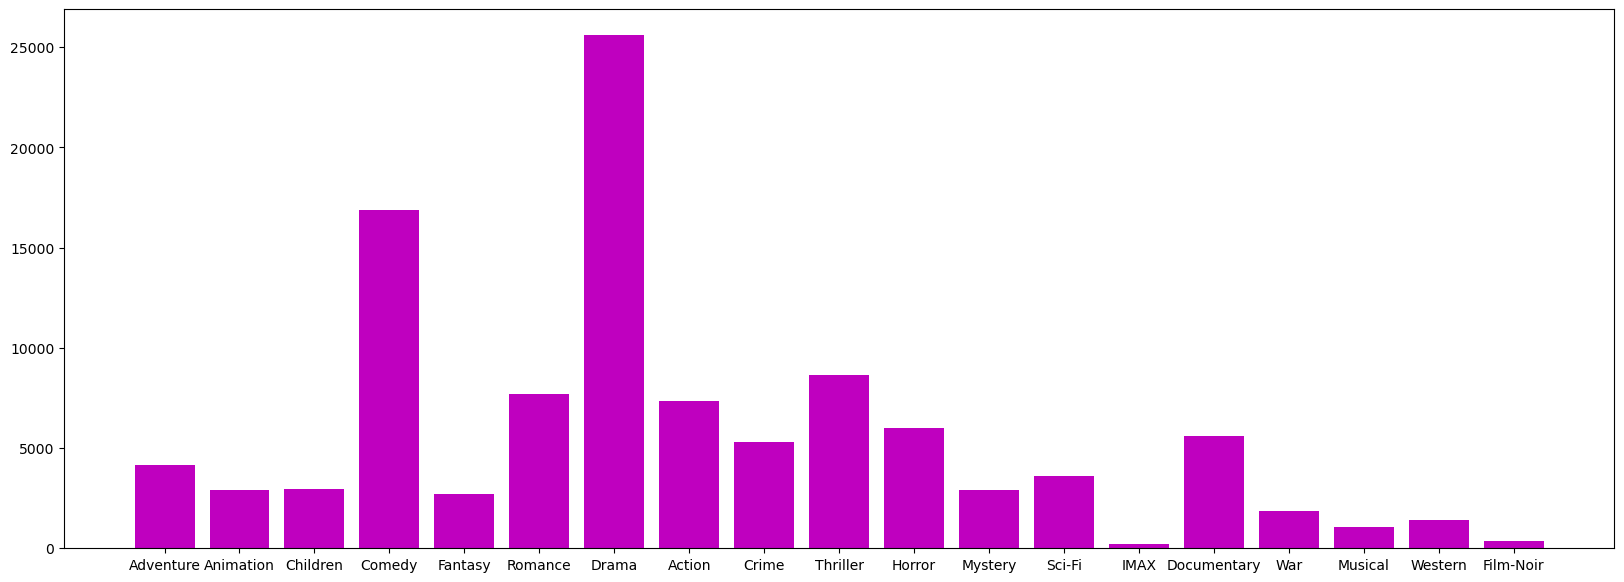

In [17]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [18]:
df_ratings.head(5)

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

### Distribution of users rating

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


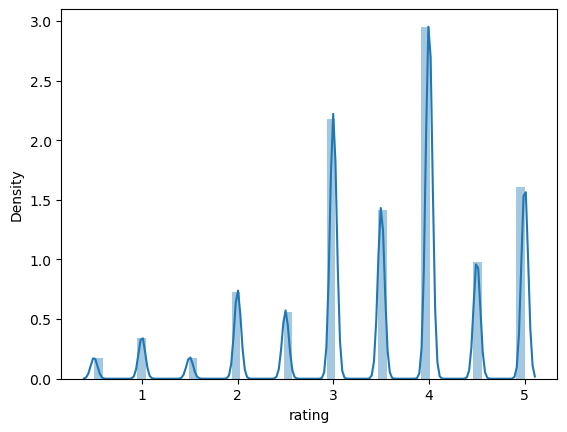

In [19]:
sns.distplot(df_ratings["rating"]);

In [20]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(25000095, 4)
 Movies DataFrame(62423, 3)


In [21]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [22]:
merge_ratings_movies.head(2)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       2     3.5  1141415820  
1       3     4.0  1439472215

In [23]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [24]:
merge_ratings_movies.shape

(25000095, 5)

#### Grouping the rating based on user

In [25]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

C:\Users\Admin\AppData\Local\Temp\ipykernel_17164\325471676.py:1: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])


In [26]:
ratings_grouped_by_users.tail(2)

movieId               rating          
          size          mean   size      mean
userId                                       
162540      88  30583.659091     88  3.829545
162541     182   5023.362637    182  3.365385

In [27]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

<AxesSubplot:xlabel='userId'>

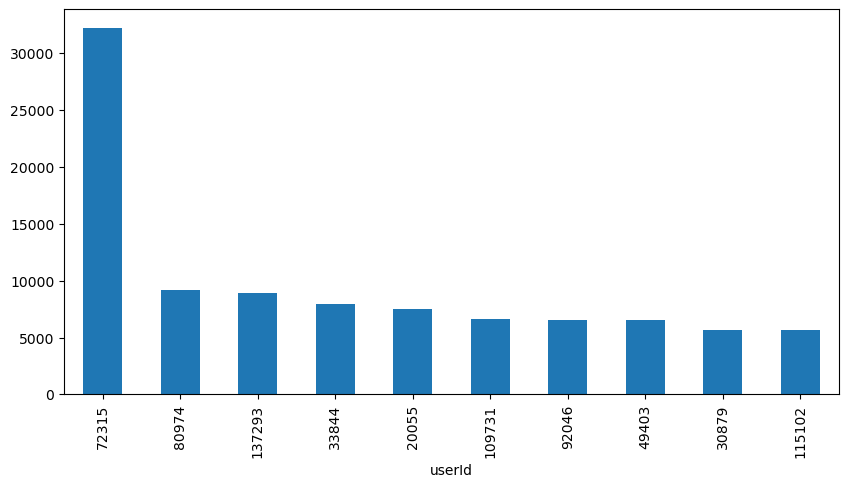

In [28]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5))

In [29]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17164\2038148947.py:1: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)


In [30]:
ratings_grouped_by_movies.shape

(59047, 2)

In [31]:
ratings_grouped_by_movies.head(3)

userId    rating
                 mean      mean
movieId                        
1        81294.564728  3.893708
2        81358.542554  3.251527
3        81343.694934  3.142028

In [32]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

### Movies with high average rating

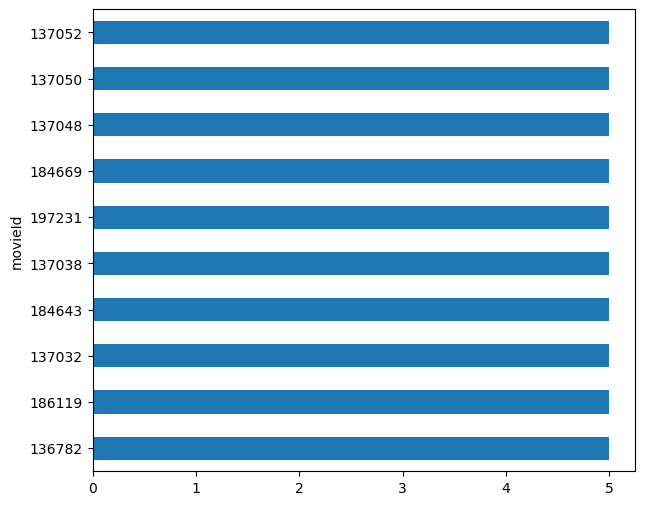

In [33]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

### Movies with low average rating

In [34]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [35]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

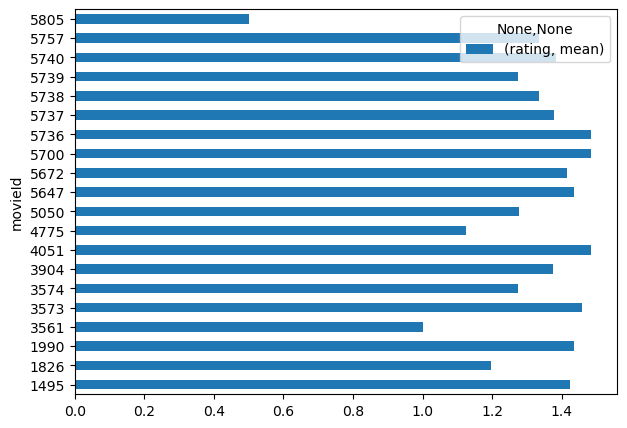

In [36]:
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5));

In [37]:
low_rated_movies.head(10)

rating
             mean
movieId          
1495     1.423077
1826     1.195214
1990     1.435065
3561     1.000000
3573     1.456790
3574     1.274074
3904     1.375000
4051     1.484127
4775     1.125561
5050     1.277778

### Create Node - Create Relationship

In [38]:
import csv

filename = "D:\ml-25m\ml-25m\movies.csv"

with open(filename, newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    # Process the CSV file using the 'reader' object


# Create node movie in graph database 

In [39]:
#import csv 

def loadMovies():
    with open(r'D:\ml-25m\ml-25m\movies.csv', newline='', encoding='utf-8') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)  # skip header
        for i, row in enumerate(readCSV):
            createMovieNodes(row)

            if i >= 1000:
                break

def createMovieNodes(row):
    movieData = parseRowMovie(row)
    id = movieData[0]
    title = movieData[1]
    year = movieData[2]
    mov = Node("Movie", id=id, title=title, year=year)
    graph.create(mov)

def parseRowMovie(row):
    id = row[0]
    year = row[1][-5:-1]
    title = row[1][:-7]

    return (id, title, year)


In [40]:
loadMovies()


# Create node genre in graph database

In [41]:
def createGenreNodes():
    allGenres = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                 "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
                 "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

    for genre in allGenres:
        gen = Node("Genre", name=genre)
        graph.create(gen)



In [42]:
createGenreNodes()


# Create relationship between Genre and Movie

In [43]:
def createGenreMovieRelationships(row):
    movieId = row[0]
    movieGenres = row[2].split("|")

    for movieGenre in movieGenres:
        graph.run('MATCH (g:Genre {name: {genre}}), (m:Movie {id: {movieId}}) CREATE (g)-[:IS_GENRE_OF]->(m)',
            genre=movieGenre, movieId=movieId)

def parseRowGenreMovieRelationships(row):
    movieId = row[0]
    movieGenres = row[2].split("|")

    return (movieId, movieGenres)


In [44]:
import csv

def loadGenreMovieRelationships():
    with open(r'D:\ml-25m\ml-25m\movies.csv', newline='', encoding='utf-8') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)  # skip header
        for i, row in enumerate(readCSV):
            createGenreMovieRelationships(row)

            if i >= 1000:
                break

def createGenreMovieRelationships(row):
    movie_id = row[0]
    genre_list = row[2].split("|")  # Assuming genre column is at index 2
    for genre in genre_list:
        createRelationship(genre, movie_id)

def createRelationship(genre, movie_id):
    query = "MATCH (g:Genre {name: $genre}), (m:Movie {id: $movie_id}) CREATE (g)-[:IS_GENRE_OF]->(m)"
    graph.run(query, genre=genre, movie_id=movie_id)


In [ ]:
loadGenreMovieRelationships()


# Create relationship between User And Rating 

In [46]:
def createUserNodes(row):
    user = Node("User", id="User " + row[0])
    graph.merge(user, "User", "id")

def createRatingRelationship(row):
    ratingData = parseRowRatingRelationships(row)

    graph.run(
        'MATCH (u:User {id: $userId}), (m:Movie {id: $movieId}) CREATE (u)-[:RATED {rating: $rating, timestamp: $timestamp}]->(m)',
        userId=ratingData[0], movieId=ratingData[1], rating=ratingData[2], timestamp=ratingData[3])

def parseRowRatingRelationships(row):
    userId = "User " + row[0]
    movieId = row[1]
    rating = float(row[2])
    timestamp = row[3]

    return (userId, movieId, rating, timestamp)

In [47]:
def loadRatings():
    with open(r'D:\ml-20m\ml-20m\ratings.csv') as csvfile:
         readCSV = csv.reader(csvfile, delimiter=',')
         next(readCSV, None) #skip header
         for i,row in enumerate(readCSV):
#              print(row)
             createUserNodes(row)
             createRatingRelationship(row)

             if (i >= 1000):
                 break

In [ ]:
loadRatings()


# Content based filtering
The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

### Term Frequency (TF) and Inverse Document Frequency (IDF)
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

We will consider genres as an important parameter to recommend user the movie he watches based on generes of movie user has already watched.

![](https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336)

For calculating distances, many similarity coefficients can be calculated. Most widely used similarity coefficients are 
- Euclidean
- Cosine
- Pearson Correlation 
etc..

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as Inline-style:

![](https://i.stack.imgur.com/36r1U.png)

In [6]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [7]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]


In [10]:
get_recommendations_based_on_genres("Toy Story (1995)")

1706           Antz (1998)
2355    Toy Story 2 (1999)
Name: title, dtype: object

In [11]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Robin Hood, The (1938)',
 'Alamo, The (1960)',
 'Alien Nation (1988)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Antz (1998)',
 'Aristocats, The (1970)',
 'Around the World in 80 Days (1956)',
 'Assassins (1995)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'BURN-E (2008)',
 'Babes in Toyland (1934)',
 'Backbeat (1993)',
 'Barb Wire (1996)',
 'Batman: Mystery of the Batwoman (2003)',
 'Beat the Devil (1953)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Ben-Hur (1959)',
 'Big Bully (1996)',
 'Big Country, The (1958)',
 'Big Trouble in Little China (1986)',
 'Black Hole, The (1979)',
 'Blazing Saddles (1974)',
 'Blues Brothers 2000 (1998)',
 'Boot, Das (Boat, The) (1981)',
 'Bride of Frankenstein, The (Bride of Frankenstein) (1935)',
 'Broken Arrow (19

# Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user 

In [13]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [14]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Hit:0.9325087251077807
Fault:0.06749127489221926


D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

# Collaborative Filtering
Types of collaborative filtering techniques
* Memory based 
 - User-Item Filtering
 - Item-Item Filtering
* Model based 
 - Matrix Factorization
 - Clustering
 - Deep Learning

## Memory Based Approach

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

- **Jaccard Similarity**
- **Cosine Similarity** 
- **Pearson Similarity** 

## Item-Item Filtering
Item-item collaborative filtering, or item-based, or item-to-item, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.


Item-item collaborative filtering was invented and used by Amazon.com

ITEM-ITEM collaborative filtering look for items that are similar to the articles that user has already rated and recommend most similar articles. But what does that mean when we say item-item similarity? In this case we don’t mean whether two items are the same by attribute like Fountain pen and pilot pen are similar because both are pen. Instead, what similarity means is how people treat two items the same in terms of like and dislike.

It is quite similar to previous algorithm, but instead of finding user’s look-alike, we try finding movie’s look-alike. Once we have movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

## Implementation of Item-Item Filtering

In [15]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [16]:
df_movies_ratings

movieId                                      title  \
0             1                           Toy Story (1995)   
1             1                           Toy Story (1995)   
2             1                           Toy Story (1995)   
3             1                           Toy Story (1995)   
4             1                           Toy Story (1995)   
...         ...                                        ...   
100831   193581  Black Butler: Book of the Atlantic (2017)   
100832   193583               No Game No Life: Zero (2017)   
100833   193585                               Flint (2017)   
100834   193587        Bungo Stray Dogs: Dead Apple (2018)   
100835   193609        Andrew Dice Clay: Dice Rules (1991)   

                                             genres  userId  rating  \
0       Adventure|Animation|Children|Comedy|Fantasy       1     4.0   
1       Adventure|Animation|Children|Comedy|Fantasy       5     4.0   
2       Adventure|Animation|Children|Comedy|Fantasy       7     4.5   
3       Adventure|Animation|Children|Comedy|Fantasy      15     2.5   
4       Adventure|Animation|Children|Comedy|Fantasy      17     4.5   
...                                             ...     ...     ...   
100831              Action|Animation|Comedy|Fantasy     184     4.0   
100832                     Animation|Comedy|Fantasy     184     3.5   
100833                                        Drama     184     3.5   
100834                             Action|Animation     184     3.5   
100835                                       Comedy     331     4.0   

         timestamp  
0        964982703  
1        847434962  
2       1106635946  
3       1510577970  
4       1305696483  
...            ...  
100831  1537109082  
100832  1537109545  
100833  1537109805  
100834  1537110021  
100835  1537157606  

[100836 rows x 6 columns]

Here Pivot table function is used as we want one to one maping between movies, user and their rating. 
So by default pivot_table command takes average if we have multiple values of one combination.

In [17]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)


In [18]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Replace missing values with 0
ratings_matrix_items.fillna(0, inplace=True)

# Calculate the similarity matrix
movie_similarity = 1 - pairwise_distances(ratings_matrix_items.values, metric="cosine")
np.fill_diagonal(movie_similarity, 0)  # Filling diagonals with 0s for future use when sorting is done

# Create DataFrame from similarity matrix
ratings_matrix_items = pd.DataFrame(movie_similarity)
ratings_matrix_items


0         1         2         3         4         5         6     \
0     0.000000  0.410562  0.296917  0.035573  0.308762  0.376316  0.277491   
1     0.410562  0.000000  0.282438  0.106415  0.287795  0.297009  0.228576   
2     0.296917  0.282438  0.000000  0.092406  0.417802  0.284257  0.402831   
3     0.035573  0.106415  0.092406  0.000000  0.188376  0.089685  0.275035   
4     0.308762  0.287795  0.417802  0.188376  0.000000  0.298969  0.474002   
...        ...       ...       ...       ...       ...       ...       ...   
9719  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9720  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9721  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9722  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9723  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9     ...  9714  9715  9716  9717  9718  9719  \
0     0.131629  0.232586  0.395573  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1     0.172498  0.044835  0.417693  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2     0.313434  0.304840  0.242954  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3     0.158022  0.000000  0.095598  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4     0.283523  0.335058  0.218061  ...   0.0   0.0   0.0   0.0   0.0   0.0   
...        ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
9719  0.000000  0.000000  0.000000  ...   1.0   1.0   1.0   1.0   1.0   0.0   
9720  0.000000  0.000000  0.000000  ...   1.0   1.0   1.0   1.0   1.0   1.0   
9721  0.000000  0.000000  0.000000  ...   1.0   1.0   1.0   1.0   1.0   1.0   
9722  0.000000  0.000000  0.000000  ...   1.0   1.0   1.0   1.0   1.0   1.0   
9723  0.000000  0.000000  0.072542  ...   0.0   0.0   0.0   0.0   0.0   0.0   

      9720  9721  9722  9723  
0      0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...  
9719   1.0   1.0   1.0   0.0  
9720   0.0   1.0   1.0   0.0  
9721   1.0   0.0   1.0   0.0  
9722   1.0   1.0   0.0   0.0  
9723   0.0   0.0   0.0   0.0  

[9724 rows x 9724 columns]

Below function will take the movie name as a input and will find the movies which are similar to this movie.
This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

In [20]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

Here we provide the user id of the user for which we have to recommend movies.
Then we find the movies which are rated 5 or 4.5 by the user for whom we want to recommend movies.
We are finding this because as we know that in Item-Item similarity approach we recommended movies to the user based on his previous selection.
So to foster our algorithm we are finding movies which are liked by the user most and on bases of that we will recommend movies with are similar to movies highly rated by the user.
Then our function has appended the similarity of the movie highly rated by the user to our movies data frame.
Now we will sort the frame as per the similarity in descending order so that we can get the movies which are highly similar to movie highly rated bu our customer.
Now we filter the movies which are most similar as per the similarity so if similarity is greater than 0.45 then we are considering the movies.
Now the function goes ahead and see which all movies user has seen and then filter out the movies which he has not seen and than recommended that movies to him.

In [21]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [22]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [23]:
user_id=50 
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [659    Godfather, The (1972)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 1644    Willow (1988)
Name: title, dtype: object]


In [24]:
userid = 'User 1'
n = 10


In [ ]:
rec = graph.run(
    '''
    MATCH (u1:User {id: $userid})-[r:RATED]->(m:Movie)
    WITH u1, avg(r.rating) AS u1_mean
    MATCH (u1)-[r1:RATED]->(m:Movie)<-[r2:RATED]-(u2)
    WITH u1, u1_mean, u2, COLLECT({r1: r1, r2: r2}) AS ratings WHERE size(ratings) > 5
    MATCH (u2)-[r:RATED]->(m:Movie)
    WITH u1, u1_mean, u2, avg(r.rating) AS u2_mean, ratings
    UNWIND ratings AS r
    WITH sum((r.r1.rating - u1_mean) * (r.r2.rating - u2_mean)) AS nom,
         sqrt(sum((r.r1.rating - u1_mean) ^ 2) * sum((r.r2.rating - u2_mean) ^ 2)) AS denom,
         u1, u2 WHERE denom <> 0
    WITH u1, u2, nom / denom AS pearson
    ORDER BY pearson DESC LIMIT 10
    MATCH (u2)-[r:RATED]->(m:Movie) WHERE NOT EXISTS((u1)-[:RATED]->(m))
    RETURN m.title AS title, SUM(r.rating*pearson) AS score
    ORDER BY score DESC LIMIT toInteger($n)
    ''',
    userid=userid,
    n=n
)


In [ ]:
rec.data()

## User-Item Filtering
The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.


Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

## Implementation of User-Item Filtering

In similar way as we did for ItemItem similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then in similar ways we will find distance and similarity between users.

In [31]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)


In [32]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Replace missing values with 0
ratings_matrix_users.fillna(0, inplace=True)

# Calculate the similarity matrix
movie_similarity = 1 - pairwise_distances(ratings_matrix_users.values, metric="cosine")
np.fill_diagonal(movie_similarity, 0)  # Filling diagonals with 0s for future use when sorting is done

# Create DataFrame from similarity matrix
ratings_matrix_users = pd.DataFrame(movie_similarity)
ratings_matrix_users


0         1         2         3         4         5         6    \
0    0.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
1    0.027283  0.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
2    0.059720  0.000000  0.000000  0.002251  0.005020  0.003936  0.000000   
3    0.194395  0.003726  0.002251  0.000000  0.128659  0.088491  0.115120   
4    0.129080  0.016614  0.005020  0.128659  0.000000  0.300349  0.108342   
..        ...       ...       ...       ...       ...       ...       ...   
605  0.164191  0.028429  0.012993  0.200395  0.106435  0.102123  0.200035   
606  0.269389  0.012948  0.019247  0.131746  0.152866  0.162182  0.186114   
607  0.291097  0.046211  0.021128  0.149858  0.135535  0.178809  0.323541   
608  0.093572  0.027565  0.000000  0.032198  0.261232  0.214234  0.090840   
609  0.145321  0.102427  0.032119  0.107683  0.060792  0.052668  0.193219   

          7         8         9    ...       600       601       602  \
0    0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
1    0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
2    0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
3    0.062969  0.011361  0.031163  ...  0.085938  0.128273  0.307973   
4    0.429075  0.000000  0.030611  ...  0.068048  0.418747  0.110148   
..        ...       ...       ...  ...       ...       ...       ...   
605  0.099388  0.075898  0.088963  ...  0.178084  0.116534  0.300669   
606  0.185142  0.011844  0.010451  ...  0.092525  0.199910  0.203540   
607  0.187233  0.100435  0.077424  ...  0.158355  0.197514  0.232771   
608  0.423993  0.000000  0.021766  ...  0.035653  0.335231  0.061941   
609  0.078153  0.074399  0.121072  ...  0.222491  0.087528  0.163094   

          603       604       605       606       607       608       609  
0    0.070669  0.153625  0.164191  0.269389  0.291097  0.093572  0.145321  
1    0.000000  0.000000  0.028429  0.012948  0.046211  0.027565  0.102427  
2    0.000000  0.010694  0.012993  0.019247  0.021128  0.000000  0.032119  
3    0.052985  0.084584  0.200395  0.131746  0.149858  0.032198  0.107683  
4    0.258773  0.148758  0.106435  0.152866  0.135535  0.261232  0.060792  
..        ...       ...       ...       ...       ...       ...       ...  
605  0.066032  0.148141  0.000000  0.153063  0.262558  0.069622  0.201104  
606  0.137834  0.118780  0.153063  0.000000  0.283081  0.149190  0.139114  
607  0.155306  0.178142  0.262558  0.283081  0.000000  0.121993  0.322055  
608  0.236601  0.097610  0.069622  0.149190  0.121993  0.000000  0.053225  
609  0.052552  0.119295  0.201104  0.139114  0.322055  0.053225  0.000000  

[610 rows x 610 columns]

In [33]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [34]:
df_similar_user.columns=['similarUser']

In [35]:
df_similar_user

similarUser
0            265
1            365
2            312
3            390
4            469
..           ...
605          473
606          569
607          479
608          339
609          248

[610 rows x 1 columns]

Below function takes id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user.

In [36]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [37]:
user_id=200
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


In [ ]:
n = int(n)  # Convert n to an integer

rec_2 = graph.run(
    '''
    MATCH (m1:Movie)<-[r1:RATED]-(u1:User {id: $userid})
    WITH m1, avg(r1.rating) AS m1_mean
    MATCH (m2:Movie)<-[r2:RATED]-(u2:User)
    WHERE m1 <> m2
    WITH m1, m1_mean, m2, COLLECT({rating: r2.rating, user: u2}) AS ratings
    WHERE size(ratings) > 5
    WITH m1, m1_mean, m2, ratings,
         SQRT(REDUCE(sumSquares = 0.0, r in ratings | sumSquares + r.rating^2.0)) AS m2_norm
    UNWIND ratings AS r
    WITH m1, m1_mean, m2, r.user AS u2, r.rating AS m2_rating, m2_norm
    MATCH (u1:User)-[r3:RATED]->(m1)
    WITH m1, m1_mean, m2, u2, m2_rating, m2_norm, m1_mean - r3.rating AS diff, r3
    WITH m1, m2, COLLECT(diff * (m2_rating / (m2_norm * SQRT(m1_mean^2.0 + r3.rating^2.0)))) AS similarities
    WITH m1, m2, REDUCE(similarity = 0.0, s in similarities | similarity + s) AS cosine_sim
    ORDER BY cosine_sim DESC LIMIT $n
    MATCH (u1:User)-[r4:RATED]->(m2)
    WHERE NOT EXISTS((u1)-[:RATED]->(m1))
    RETURN m2.title AS title, SUM(cosine_sim * r4.rating) AS score
    ORDER BY score DESC LIMIT $n
    ''',
    userid=userid,
    n=n
)


In [ ]:
rec_2.data()

# Evaluating the model

In [38]:
def get_user_similar_movies( user1, user2 ):
    
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [39]:
get_user_similar_movies(10,110)

title_x  userId_x  rating_x  userId_y  rating_y
0      Pulp Fiction (1994)        10       1.0       110       4.5
1       Matrix, The (1999)        10       0.5       110       4.0
2  Sixth Sense, The (1999)        10       0.5       110       3.0
3   American Beauty (1999)        10       1.0       110       4.5
4        Fight Club (1999)        10       0.5       110       4.5

## Pros and Cons of two methods

Challenges with User similarity
- The challenge with calculating user similarity is the user need to have some prior purchases and should have rated them.
- This recommendation technique does not work for new users.
- The system need to wait until the user make some purchases and rates them. Only then similar users can be found and recommendations can be made. This is called cold start problem.

# Model-Based

# Single Value Decomposition

Singular value decomposition is a method of decomposing a matrix into three other matrices:

In [41]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv(r"D:\doan\ratingss.csv", sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('D:\doan\moviess.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [43]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]


In [44]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  193583  193585  193587  193609  
userId                                   
1           0.0     0.0     0.0     0.0  
2           0.0     0.0     0.0     0.0  
3           0.0     0.0     0.0     0.0  
4           0.0     0.0     0.0     0.0  
5           0.0     0.0     0.0     0.0  

[5 rows x 9724 columns]

In [47]:
import numpy as np
import pandas as pd

# Assuming you have a DataFrame called 'Ratings' with ratings data

# Get the underlying NumPy array from the DataFrame
R = Ratings.values

# Calculate the mean ratings for each user
user_ratings_mean = np.mean(R, axis=1)
print(user_ratings_mean.size)
# Subtract the mean ratings from the original ratings matrix
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)


610


## Model-Based Collaborative Filtering

<b>Model-based Collaborative Filtering</b> is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

   * The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
   * When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
   * You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

For example, let's check the sparsity of the ratings dataset:

In [48]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens25M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens25M dataset is 98.3%


## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. We are going to use the Scipy function svds because it let’s us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [49]:
from scipy.sparse.linalg import svds 

In [50]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [51]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


As we are going to leverage matrix multiplication to get predictions, we willl convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [52]:
sigma = np.diag(sigma)

In [53]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [54]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


## Making Predictions from the Decomposed Matrices

We now have everything we need to make movie ratings predictions for every user. We can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, we need to add the user means back to get the actual star ratings prediction.

In [55]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [56]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (610, 9724)


With the predictions matrix for every user, we can build a function to recommend movies for any user. We return the list of movies the user has already rated, for the sake of comparison.

We will use the column names from the ratings df

In [58]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)


In [59]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId    1         2         3         4         5         6         7       \
0        2.167328  0.402751  0.840184 -0.076281 -0.551337  2.504091 -0.890114   
1        0.211459  0.006658  0.033455  0.017419  0.183430 -0.062473  0.083037   
2        0.003588  0.030518  0.046393  0.008176 -0.006247  0.107328 -0.012416   
3        2.051549 -0.387104 -0.252199  0.087562  0.130465  0.270210  0.477835   
4        1.344738  0.778511  0.065749  0.111744  0.273144  0.584426  0.254930   

movieId    8         9         10      ...    193565    193567    193571  \
0       -0.026443  0.196974  1.593259  ... -0.023453 -0.019967 -0.026939   
1        0.024158  0.049330 -0.152530  ...  0.019498  0.016777  0.022219   
2        0.003779  0.007297 -0.059362  ...  0.005909  0.006209  0.005610   
3        0.040313  0.025858 -0.017365  ...  0.004836  0.004172  0.005500   
4        0.128788 -0.085541  1.023455  ... -0.008042 -0.007419 -0.008664   

movieId    193573    193579    193581    193583    193585    193587    193609  
0       -0.026939 -0.023453 -0.026939 -0.023453 -0.023453 -0.023453 -0.058732  
1        0.022219  0.019498  0.022219  0.019498  0.019498  0.019498  0.032281  
2        0.005610  0.005909  0.005610  0.005909  0.005909  0.005909  0.008004  
3        0.005500  0.004836  0.005500  0.004836  0.004836  0.004836 -0.023311  
4       -0.008664 -0.008042 -0.008664 -0.008042 -0.008042 -0.008042 -0.010127  

[5 rows x 9724 columns]

Now we write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though we didn't use any explicit movie content features (such as genre or title), we will merge in that information to get a more complete picture of the recommendations.

In [61]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 175.

In [62]:
already_rated, predictions = recommend_movies(preds, 175, movies, ratings, 20)

User 175 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [63]:
# Top 20 movies that User 175 has rated 
already_rated.head(20)

userId  movieId  rating   timestamp  \
12     175     8911     5.0  1234189764   
13     175    32289     5.0  1234189413   
21     175    47382     5.0  1234189512   
4      175     3594     5.0  1234188487   
5      175     3791     5.0  1234188252   
8      175     7169     5.0  1234189772   
19     175    44613     5.0  1234189390   
16     175    38388     5.0  1234189433   
6      175     3969     4.5  1234188201   
11     175     8643     4.5  1234189498   
22     175    56949     4.0  1234189781   
20     175    45880     4.0  1234188588   
23     175    58107     4.0  1234189514   
2      175     2300     4.0  1234188170   
14     175    33145     3.5  1234189063   
15     175    33880     3.5  1234188574   
10     175     8362     3.5  1234188705   
9      175     7259     3.5  1234189558   
0      175      531     3.5  1234188140   
1      175      671     0.5  1234188159   

                                             title                 genres  
12                         Raise Your Voice (2004)                Romance  
13                             Ice Princess (2005)  Children|Comedy|Drama  
21                                  Step Up (2006)          Drama|Romance  
4                              Center Stage (2000)          Drama|Musical  
5                                 Footloose (1984)                  Drama  
8                           Chasing Liberty (2004)         Comedy|Romance  
19                            Take the Lead (2006)                  Drama  
16           Goal! The Dream Begins (Goal!) (2005)                  Drama  
6                            Pay It Forward (2000)                  Drama  
11                      Cinderella Story, A (2004)         Comedy|Romance  
22                               27 Dresses (2008)         Comedy|Romance  
20                         Marie Antoinette (2006)          Drama|Romance  
23                    Step Up 2 the Streets (2008)  Drama|Musical|Romance  
2                            Producers, The (1968)                 Comedy  
14                         Lot Like Love, A (2005)   Comedy|Drama|Romance  
15          Me and You and Everyone We Know (2005)           Comedy|Drama  
10                            Raising Helen (2004)   Comedy|Drama|Romance  
9                            You Got Served (2004)          Drama|Musical  
0                        Secret Garden, The (1993)         Children|Drama  
1   Mystery Science Theater 3000: The Movie (1996)          Comedy|Sci-Fi

In [64]:
# Top 20 movies that User 175 hopefully will enjoy
predictions

movieId                                title                      genres
5216     8533                 Notebook, The (2004)               Drama|Romance
513       597                  Pretty Woman (1990)              Comedy|Romance
4153     5991                       Chicago (2002)  Comedy|Crime|Drama|Musical
3280     4447                Legally Blonde (2001)              Comedy|Romance
6040    40629             Pride & Prejudice (2005)               Drama|Romance
3978     5620            Sweet Home Alabama (2002)              Comedy|Romance
123       150                     Apollo 13 (1995)        Adventure|Drama|IMAX
4219     6155  How to Lose a Guy in 10 Days (2003)              Comedy|Romance
6200    45720        Devil Wears Prada, The (2006)                Comedy|Drama
3034     4069          Wedding Planner, The (2001)              Comedy|Romance
825      1088                 Dirty Dancing (1987)       Drama|Musical|Romance
35         39                      Clueless (1995)              Comedy|Romance
1724     2321                 Pleasantville (1998)        Comedy|Drama|Fantasy
4123     5943             Maid in Manhattan (2002)              Comedy|Romance
4934     7451                    Mean Girls (2004)                      Comedy
7392    80549                        Easy A (2010)              Comedy|Romance
3671     5066           Walk to Remember, A (2002)               Drama|Romance
6616    56367                          Juno (2007)        Comedy|Drama|Romance
3522     4823                   Serendipity (2001)              Comedy|Romance
5244     8622               Fahrenheit 9/11 (2004)                 Documentary

These look like pretty good recommendations. It's good to see that, although we didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. We have recommended some Action, Adventure, Romance, Thriller movies - all of which were genres of some of this user's top rated movies.

In [ ]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from neo4j import GraphDatabase


# Train the SVD model
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

# Get the list of movies
movies = pd.read_csv('ml-25m/movies.csv')

# Connect to Neo4j
driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Create a Neo4j session
with driver.session() as session:
    # Create movie nodes
    for _, movie in movies.iterrows():
        session.run("CREATE (:Movie {id: $id, title: $title})", id=movie['movieId'], title=movie['title'])

    # Create user nodes and movie ratings relationships
    for user_id, movie_id, rating, _ in trainset.all_ratings():
        session.run("""
            MERGE (u:User {id: $user_id})
            MERGE (m:Movie {id: $movie_id})
            MERGE (u)-[:RATED {rating: $rating}]->(m)
        """, user_id=user_id, movie_id=movie_id, rating=rating)

    # Make recommendations for a user
    user_id = 1
    user_movies = session.run("""
        MATCH (:User {id: $user_id})-[:RATED]->(m:Movie)
        RETURN m.id AS movie_id
    """, user_id=user_id)

    movie_ids = [record["movie_id"] for record in user_movies]

    for movie_id in movie_ids:
        prediction = model.predict(user_id, movie_id)
        recommended_movie = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"User {user_id} might like: {recommended_movie} (predicted rating: {prediction.est})")

# Close the Neo4j driver
driver.close()


## Model Evaluation

Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, we will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [66]:
pip install scikit-surprise



     -------------------------------------- 772.0/772.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-win_amd64.whl size=1095012 sha256=93335f789d22d7ce33d9a52d10e893a37be09eb3a3b59dbb77f52846246834be
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\c6\3a\46\9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [70]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, KFold

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Define the SVD algorithm
algo = SVD()

# Perform cross-validation using KFold
kf = KFold(n_splits=5)
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)

# Print the average RMSE and MAE scores
print('Average RMSE:', round(results['test_rmse'].mean(), 3))
print('Average MAE:', round(results['test_mae'].mean(), 3))


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8693  0.8820  0.8722  0.8674  0.8775  0.8737  0.0054  
MAE (testset)     0.6679  0.6788  0.6709  0.6672  0.6717  0.6713  0.0041  
Fit time          2.66    1.90    1.87    1.73    1.96    2.02    0.33    
Test time         2.64    0.16    0.30    0.17    0.35    0.72    0.96    
Average RMSE: 0.874
Average MAE: 0.671


In [76]:
trainset = data.build_full_trainset()
svd.fit(trainset)

We will pick again user with ID 175 and check the ratings he has given.

In [77]:
ratings[ratings['userId'] == 175]

userId  movieId  rating   timestamp
24840     175      531     3.5  1234188140
24841     175      671     0.5  1234188159
24842     175     2300     4.0  1234188170
24843     175     2526     0.5  1234188616
24844     175     3594     5.0  1234188487
24845     175     3791     5.0  1234188252
24846     175     3969     4.5  1234188201
24847     175     5410     0.5  1234188618
24848     175     7169     5.0  1234189772
24849     175     7259     3.5  1234189558
24850     175     8362     3.5  1234188705
24851     175     8643     4.5  1234189498
24852     175     8911     5.0  1234189764
24853     175    32289     5.0  1234189413
24854     175    33145     3.5  1234189063
24855     175    33880     3.5  1234188574
24856     175    38388     5.0  1234189433
24857     175    39427     0.5  1234189665
24858     175    43904     0.5  1234189741
24859     175    44613     5.0  1234189390
24860     175    45880     4.0  1234188588
24861     175    47382     5.0  1234189512
24862     175    56949     4.0  1234189781
24863     175    58107     4.0  1234189514

Now let's use SVD to predict the rating that User with ID 175 will give to a random movie (let's say with Movie ID 1994).

In [78]:
svd.predict(150, 1994)

Prediction(uid=150, iid=1994, r_ui=None, est=3.717047509644211, details={'was_impossible': False})

## SVD++
To build a robust recommender system, we need to develop models which factor in both explicit and implicit user feedback. For our Movielens dataset, a less obvious kind of implicit data does exist. The dataset does not only tell us the rating values, but also which movies users rate, regardless of how they rated these movies. In other words, a user implicitly tells us about her preferences by choosing to voice her opinion and vote a (high or low) rating. This reduces the ratings matrix into a binary matrix, where “1” stands for “rated”, and “0” for “not rated”. Admittedly, this binary data is not as vast and independent as other sources of implicit feedback could be. Nonetheless, we have found that incorporating this kind of implicit data – which inherently exist in every rating based recommender system – significantly improves prediction accuracy. SVD++ factors in this implicit feedback and gives better accuracy as shown below.

In [82]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [84]:
algo_svdpp = SVDpp(n_factors=160, n_epochs=10, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

KeyboardInterrupt: 

# Evaluating Collaborative Filtering

***Hit Ratio***
It is ratio of number of hits/ Total recommendation

In [86]:
def evaluation_collaborative_svd_model(userId,userOrItem):
    """
    hydrid the functionality of Collaborative based and svd based model to see if ratings of predicted movies 
    :param userId: userId of user, userOrItem is a boolean value if True it is User-User and if false Item-Item
    :return: dataframe of movies and ratings
    """ 
    movieIdsList= list()
    movieRatingList=list()
    movieIdRating= pd.DataFrame(columns=['movieId','rating'])
    if userOrItem== True:
        movieIdsList=getRecommendedMoviesAsperUserSimilarity(userId)
    else:
        movieIdsList=recommendedMoviesAsperItemSimilarity(user_id)
    for movieId in movieIdsList:
        predict = svd.predict(userId, movieId)
        movieRatingList.append([movieId,predict.est])
        movieIdRating = pd.DataFrame(np.array(movieRatingList), columns=['movieId','rating'])
        count=movieIdRating[(movieIdRating['rating'])>=3]['movieId'].count()
        total=movieIdRating.shape[0]
        hit_ratio= count/total
    return hit_ratio
    

In [87]:
print("Hit ratio of User-user collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,True))
print("Hit ratio of Item-Item collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,False))

Hit ratio of User-user collaborative filtering
1.0
Hit ratio of Item-Item collaborative filtering
1.0


# Hybrid model:

After developing individual models as discussed earlier, we now stack them in order to get better results.

Content Based Filtering + SVD

Steps:
1. Run Content based filtering and determine the movies which we want to recommend to the user.
2. Filter and sort the recommendations of CF using SVD predicted ratings.


In [89]:
df_movies=movies
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
#         if(predict.est < 2):
#             recommended_movies_by_content_model = recommended_movies_by_content_model.drop([key])
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]
        
user_id = 20    
hybrid_content_svd_model(user_id)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1220\1085796874.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est


movieId                                              title  \
909      1208                              Apocalypse Now (1979)   
6405    50872                                 Ratatouille (2007)   
706       924                       2001: A Space Odyssey (1968)   
254       293  LÃ©on: The Professional (a.k.a. The Profession...   
224       260          Star Wars: Episode IV - A New Hope (1977)   
903      1201  Good, the Bad and the Ugly, The (Buono, il bru...   
1545     2081                         Little Mermaid, The (1989)   
933      1233                       Boot, Das (Boat, The) (1981)   
2355     3114                                 Toy Story 2 (1999)   
1424     1947                             West Side Story (1961)   
826      1086                           Dial M for Murder (1954)   

                                           genres  svd_rating  
909                              Action|Drama|War    4.759999  
6405                     Animation|Children|Drama    4.584092  
706                        Adventure|Drama|Sci-Fi    4.502318  
254                   Action|Crime|Drama|Thriller    4.466736  
224                       Action|Adventure|Sci-Fi    4.451165  
903                      Action|Adventure|Western    4.416306  
1545    Animation|Children|Comedy|Musical|Romance    4.397191  
933                              Action|Drama|War    4.388424  
2355  Adventure|Animation|Children|Comedy|Fantasy    4.380581  
1424                        Drama|Musical|Romance    4.338498  
826                        Crime|Mystery|Thriller    4.326262

In [ ]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from neo4j import GraphDatabase

# Neo4j configuration
neo4j_uri = "bolt://localhost:7687"
neo4j_user = "your_username"
neo4j_password = "your_password"

# Load MovieLens dataset
data = Dataset.load_builtin('ml-25m')

# Train the SVD model
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

# Get the list of movies
movies = pd.read_csv('ml-25m/movies.csv')

# Connect to Neo4j
driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Create a Neo4j session
with driver.session() as session:
    # Create movie nodes
    for _, movie in movies.iterrows():
        session.run("CREATE (:Movie {id: $id, title: $title})", id=movie['movieId'], title=movie['title'])

    # Create user nodes and movie ratings relationships
    for user_id, movie_id, rating, _ in trainset.all_ratings():
        session.run("""
            MERGE (u:User {id: $user_id})
            MERGE (m:Movie {id: $movie_id})
            MERGE (u)-[:RATED {rating: $rating}]->(m)
        """, user_id=user_id, movie_id=movie_id, rating=rating)

    def get_recommendation_content_model(user_id):
        # Content-based model recommendation logic
        # Implement your content-based recommendation logic here
        pass

    def hybrid_content_svd_model(userId):
        """
        hydrid the functionality of content based and svd based model to recommend user top 10 movies.
        :param userId: userId of user
        :return: list of movies recommended with rating given by svd model
        """
        recommended_movies_by_content_model = get_recommendation_content_model(userId)
        recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
        for key, columns in recommended_movies_by_content_model.iterrows():
            predict = model.predict(userId, columns["movieId"])
            recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
        return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:10]

    user_id = 20
    recommended_movies = hybrid_content_svd_model(user_id)
    print(f"Top 10 movies recommended for user {user_id}:")
    print(recommended_movies[['title', 'svd_rating']])

# Close the Neo4j driver
driver.close()
